# **Text Summarizer Project**

To run this .ipynb file locally your system must have python 3.11 or higher version installed in it. This is the pre Requisite of this Project.

Recommended to Follow this YouTube Video : [Explanation Video](https://youtu.be/dnNRV3mdzUo)


<br>

---

<br>

- install all the necesary libraries needed.

<br>

for creating the virtual environment to install the required libraries then you can run the following code in your command prompt.

`python -m venv .venv`

`source .venv/Scripts/activate`(for Linux or MacOS) / `.venv\Scripts\activate` (for Windows)

`pip install -r requirements.txt`

or if you want to install these libraries globally then directly run the following cell. 

<br>

In [ ]:
! pip install -r requirements.txt

<br>

---

<br>

**Required Import**
- **os** - for interacting with the OS like FileSystem Management.
- **logging** - for emitting log messages while program is running. (optional to import)
- **time** - for handling time-related operations.
- **random** - for generating random numbers and manipulate collections like lists, strings, or booleans.
- **typing** - helps developers write statically typed code in a dynamically typed language.
- **dotenv** - for managing environment variables for a Python application.
- **pymupdf4llm** - for extracting text from pdf to markdown file and to work with LLM.
- **textgrad** - to optimize text by implementing LLM-gradients pipelines.
- **streamlit** - allows users to create and share data science and machine learning web apps.

<br>

> **Gradient is an LLM development platform** that offers simple web APIs for fine-tuning, embeddings, and inference on state-of-the-art open-source models


<br>




In [ ]:
import os
import logging
import time
import random
from typing import List
from dotenv import load_dotenv
import pymupdf4llm
import textgrad as tg
import streamlit as st


<br>

-  set up the logging configuration for the application. to monitor activity while program is running. Ex :-

![Screenshot 2024-11-10 181336.png](<attachment:Screenshot 2024-11-10 181336.png>)

<br>
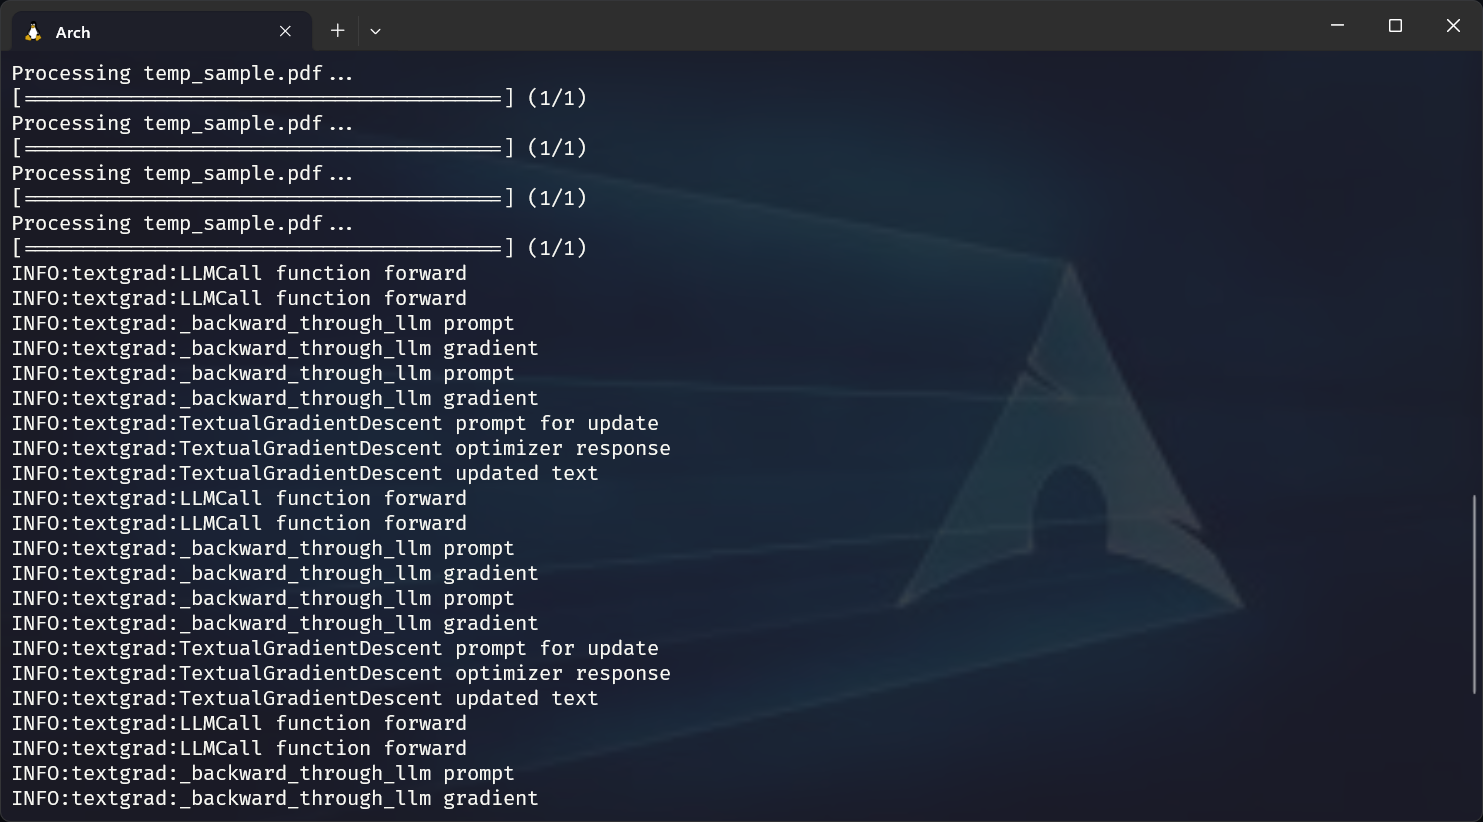

In [ ]:
# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

<br>

- Create your oen **Grop API Key** and paste that here in the place of "GROQ_API_KEY" variable.

- Steps to Get Groq API Key:
1. Go to `https://groq.com/` ang gor to DEV CONSOLE.
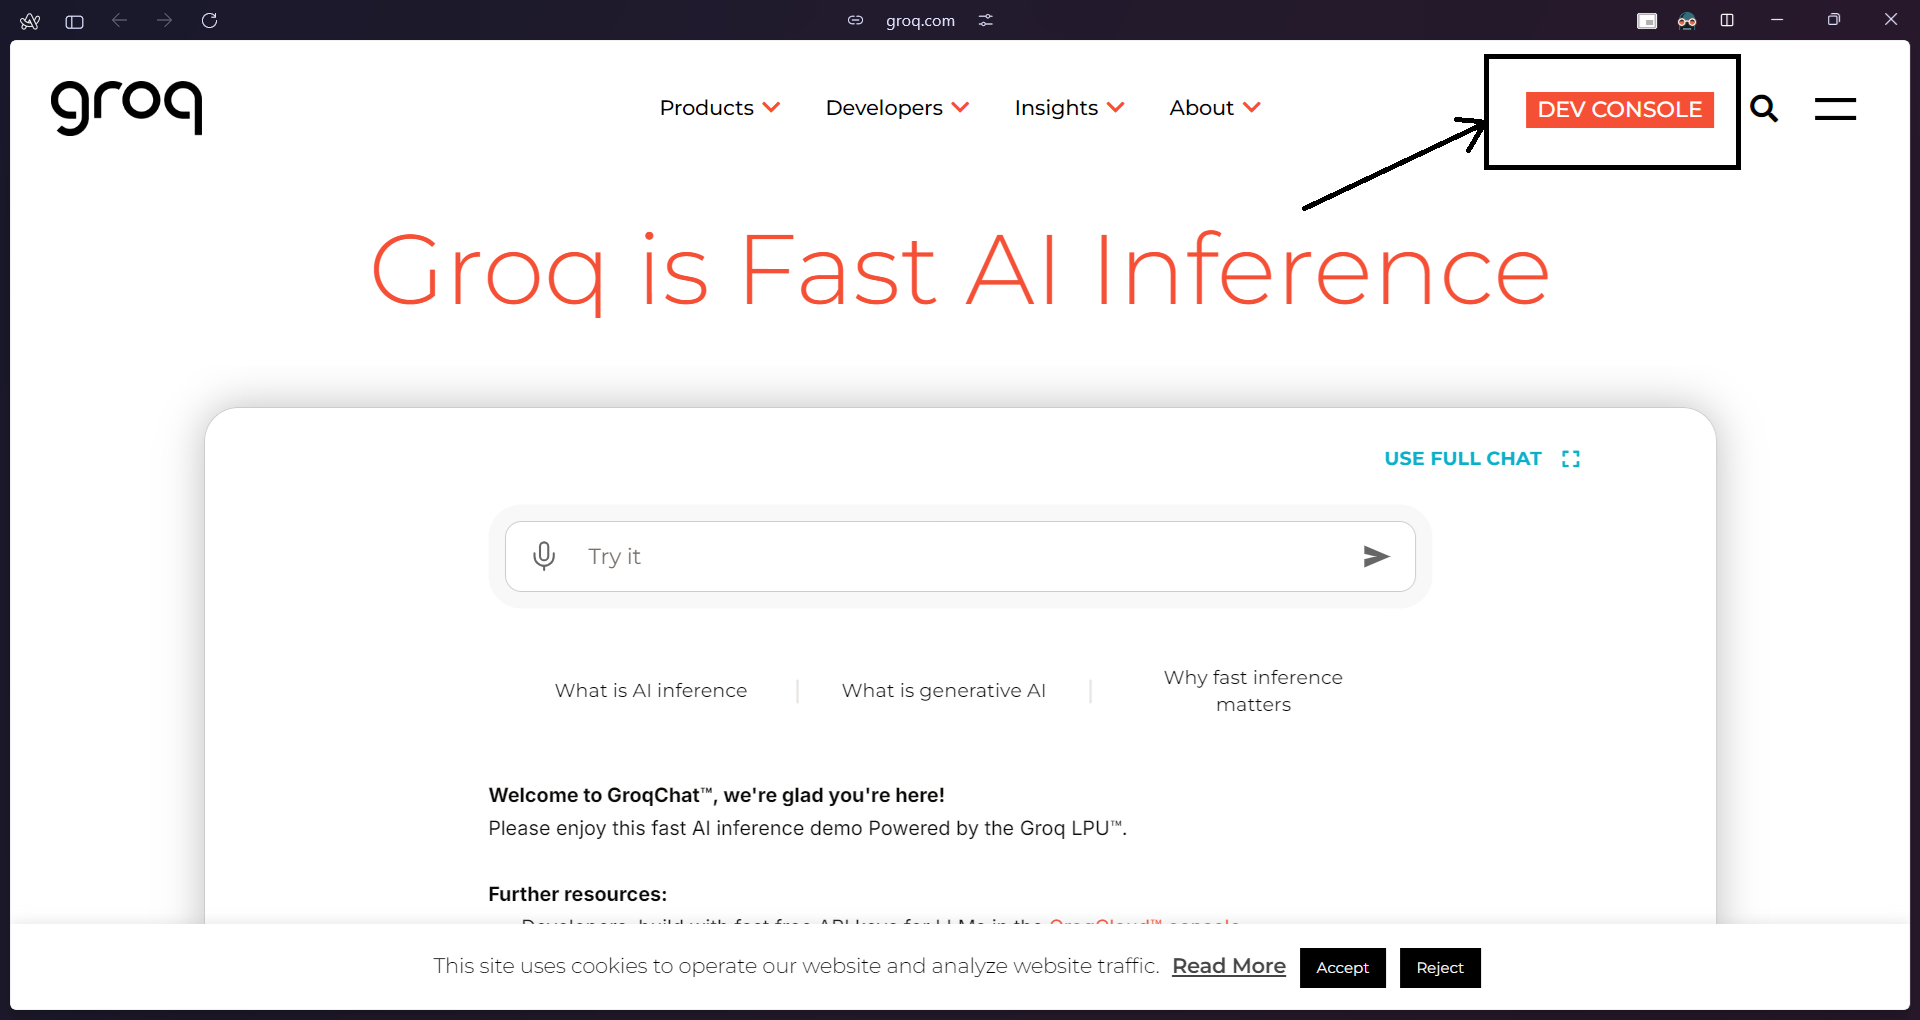
2. Then go to API Keys and then click on Create API Key.
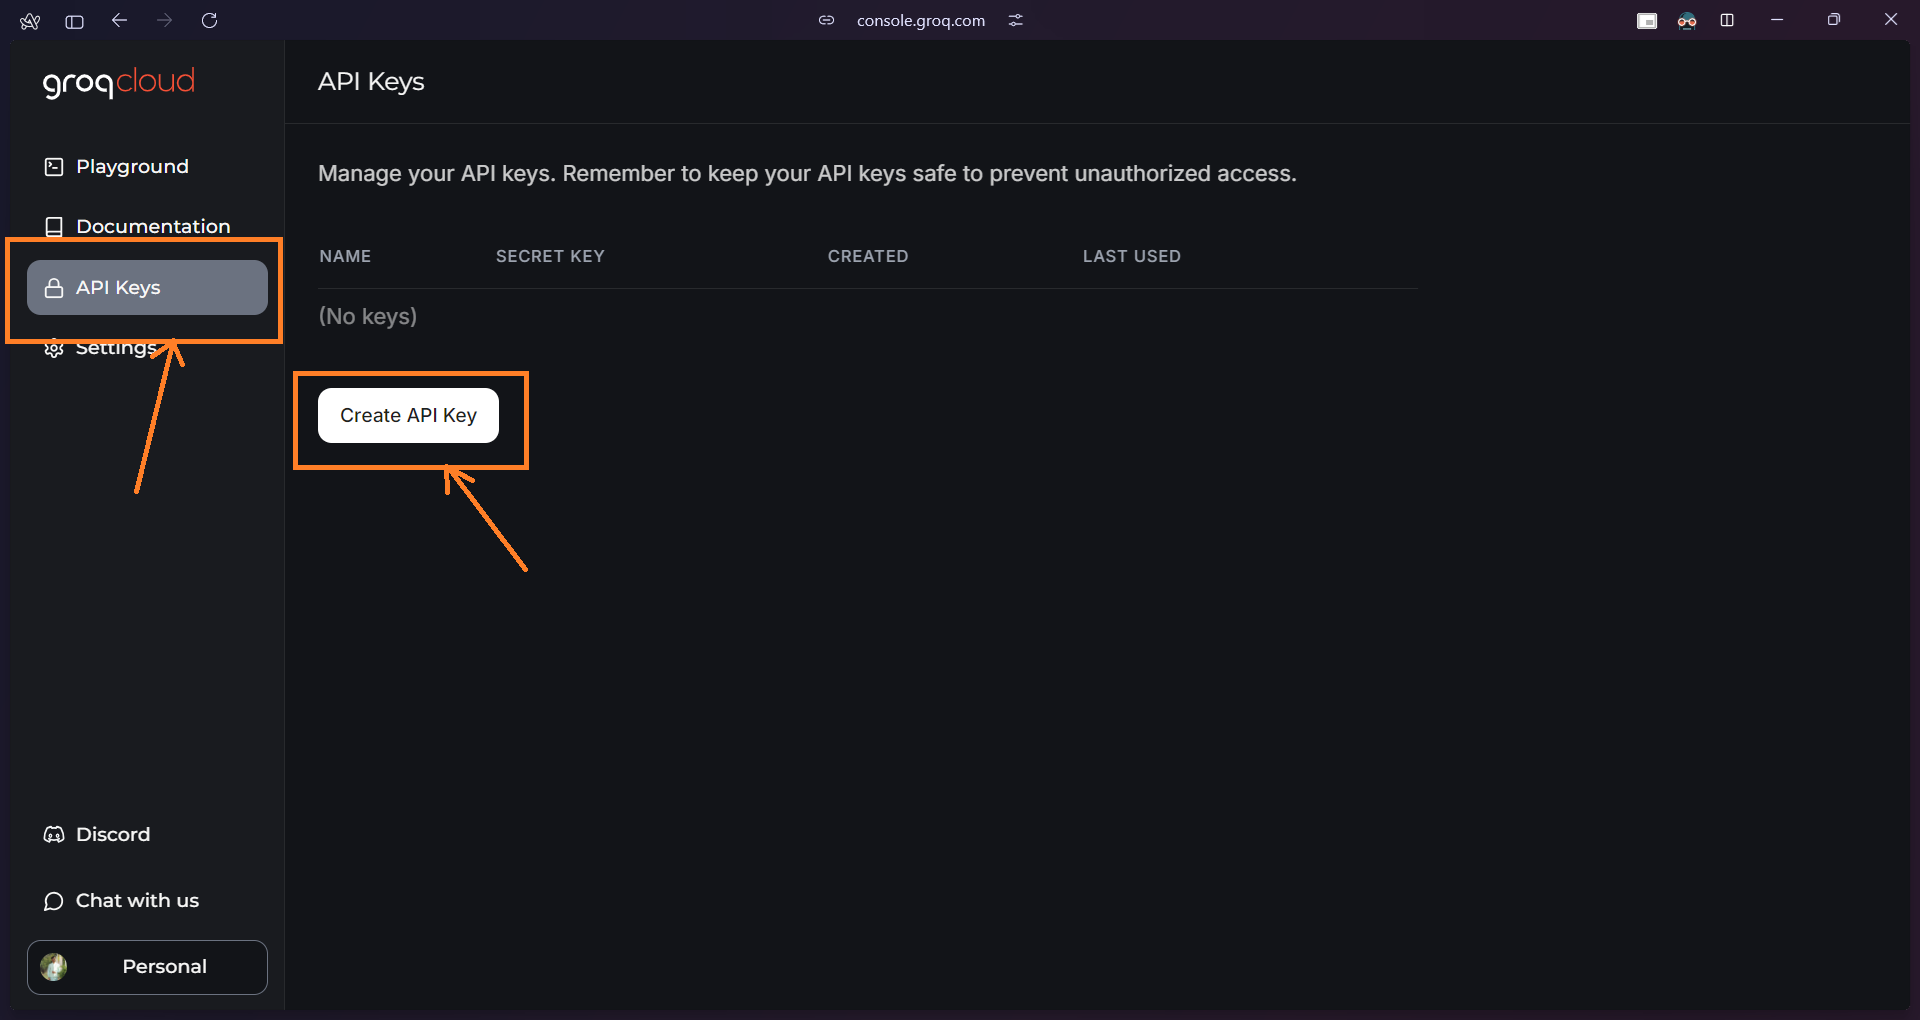
3. Then give a name anf click on submit.
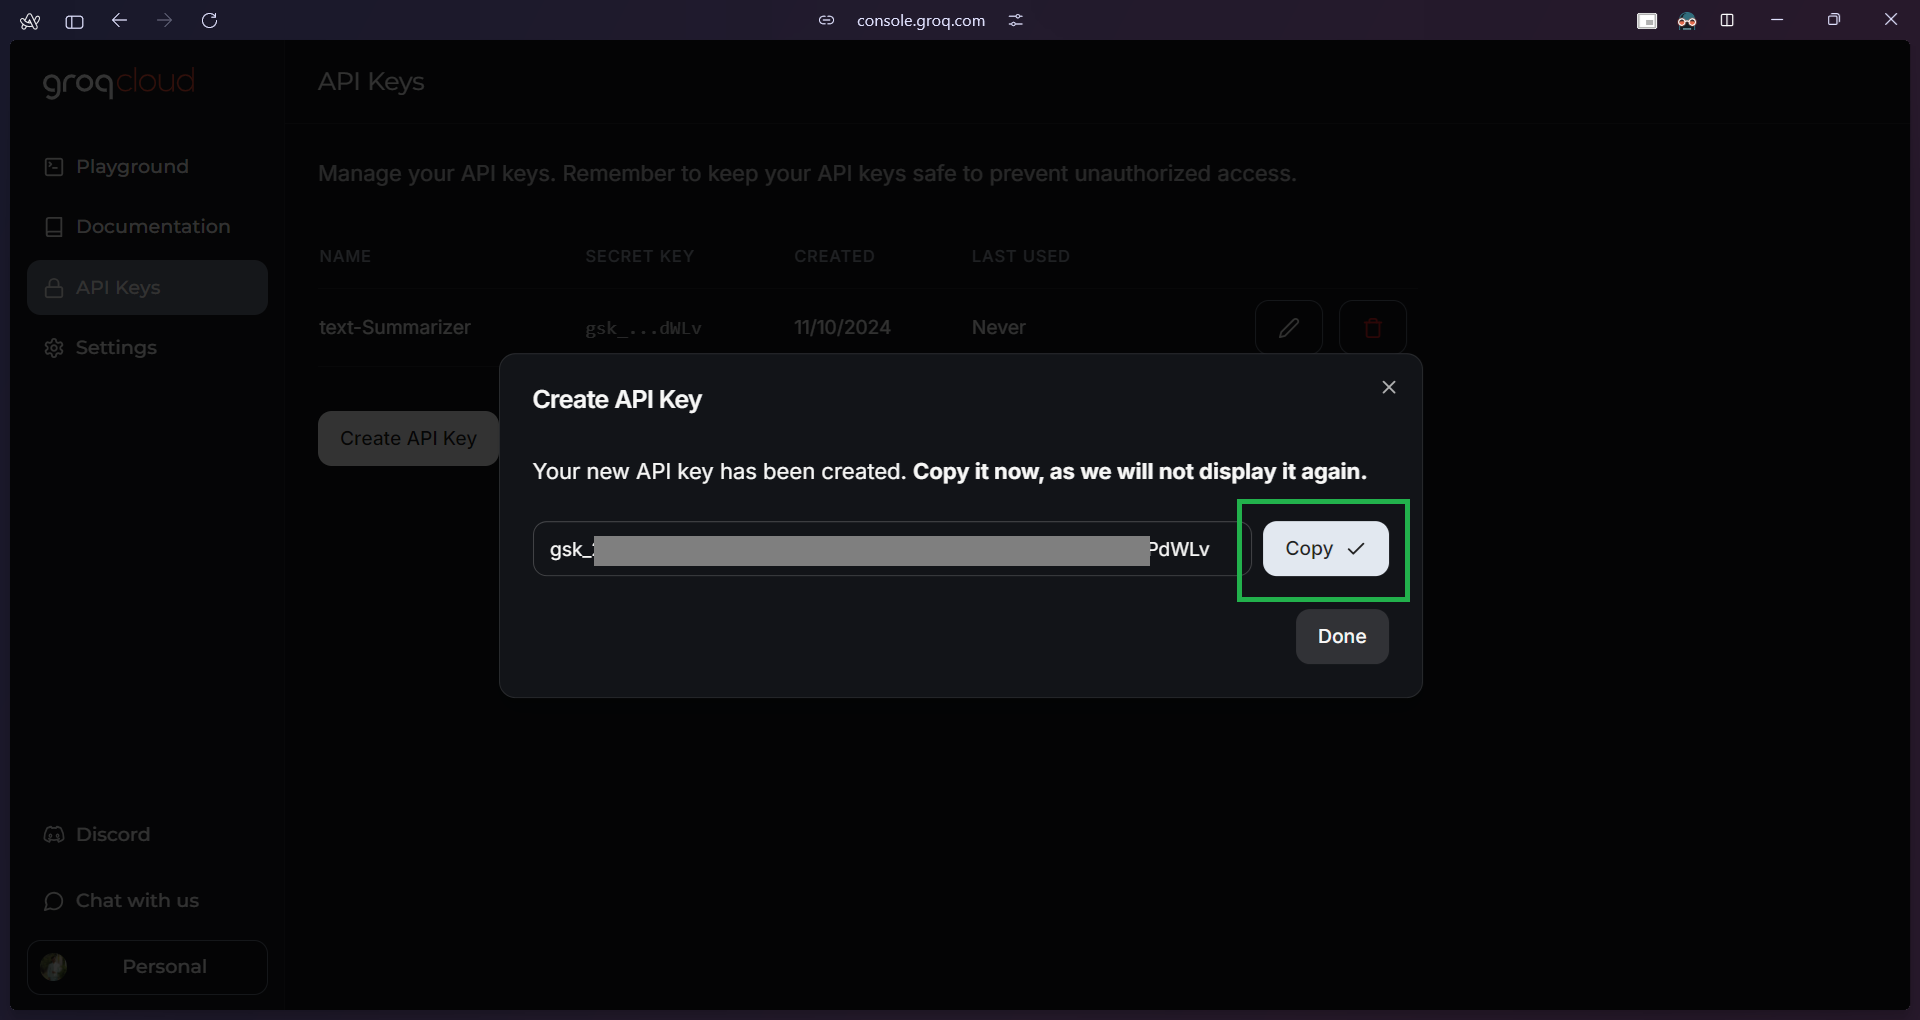
4. Then open the terminal and create an environment file `.env` and write the API key as follow.

Example :- `GROQ_API_KEY = "sfergdfvxdaw_XYZ_API_KEY"`

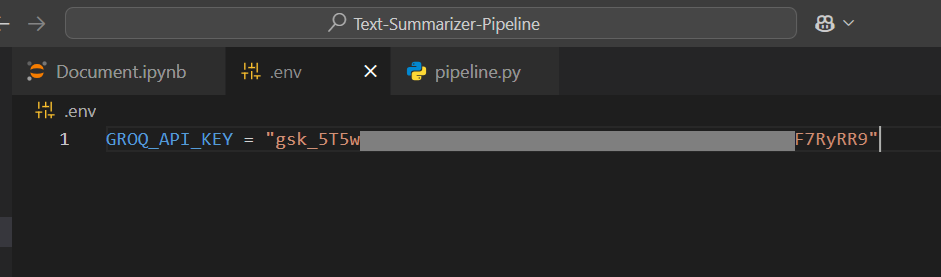
<br>

In [ ]:
# Load environment variables
load_dotenv()

# Set the GROQ_API_KEY environment variable
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
assert GROQ_API_KEY, "Please set the GROQ_API_KEY environment variable"

In [ ]:
# Define the configuration for the summarization pipeline
class PipelineConfig:

    model_name: list = [
        "gemma-7b-it",
        "gemma2-9b-it",
        "llama-3.1-70b-versatile",
        "llama-3.1-8b-instant",
        "llama-3.2-11b-text-preview",
        "llama3-8b-8192",
        "mixtral-8x7b-32768",
    ]
    # here temperature is a parameter in a LLM that controls the randomness of the model's output.
    temperature: float = 0.7
    # to authenticate the user when request is made.
    api_key: str = GROQ_API_KEY

In [ ]:
# Handles PDF reading and text extraction
class PDFProcessor: 

    @staticmethod
    def read_pdf(file_path: str) -> List[str]:
        try:
            # Extract text from PDF file using pymupdf4llm.
            llama_reader = pymupdf4llm.LlamaMarkdownReader()
            doc = llama_reader.load_data(file_path)
            return [page.text for page in doc]
        except Exception as e:
            logger.error(f"Error reading PDF: {e}")
            raise

In [ ]:
# End-to-end pipeline for PDF summarization
class SummarizationPipeline:
    
    # Initialize the pipeline with the configuration
    def __init__(self):
        self.config = PipelineConfig()
        self.model_no = 0

    # Initialize the LLM model  
    def initialize_model(self):
        llm = tg.get_engine(f"groq-{self.config.model_name[self.model_no]}")
        tg.set_backward_engine(llm, override=True)
        return tg.BlackboxLLM(llm)

    # Retry the function with backoff in case of rate limit hit
    def retry_with_backoff(self, func, *args, **kwargs):
        backoff_time = 5
        max_backoff_time = 60
        while True:
            try:
                return func(*args, **kwargs)
            except Exception:
                logger.warning(f"Rate limit hit, retrying in {backoff_time} seconds...")
                time.sleep(backoff_time)
                backoff_time = min(
                    max_backoff_time, backoff_time * 2 + random.uniform(0, 1)
                )

    # Process a batch of text
    def process_batch(self, batch_text: str) -> tg.Variable:
        system_prompt = tg.Variable(
            value=f"Here's a financial document. Provide a concise summary highlighting key takeaways. \nText: {batch_text}",
            requires_grad=True,
            role_description="system_prompt",
        )
        evaluation_instr = (
            "If nothing is important (like header, footer, introduction, title page, etc.) "
            "then just output 'No important information found'. Else, highlight the important "
            "information in key points. Do not add any additional information "
        )
        answer = self.retry_with_backoff(self.initialize_model(), system_prompt)
        self.optimize_answer(answer, evaluation_instr)
        return answer

    # Optimize the answer using the loss function
    def optimize_answer(self, answer: tg.Variable, evaluation_instr: str):
        optimizer = tg.TGD(parameters=[answer])
        loss_fn = tg.TextLoss(evaluation_instr)
        loss = loss_fn(answer)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Process the PDF file
    def process(self, file_path: str) -> str:
        try:
            with st.spinner("Reading and processing PDF..."):
                pages = PDFProcessor.read_pdf(file_path)
                # Combine pages into batches
                batch_size = 5
                batches = [
                    " ".join(pages[i : i + batch_size])
                    for i in range(0, len(pages), batch_size)
                ]

                progress_bar = st.progress(0)
                batch_summaries = []
                for i, batch in enumerate(batches):
                    batch_summaries.append(self.process_batch(batch))
                    progress_bar.progress((i + 1) / len(batches))
                    self.model_no += 1
                    self.model_no %= len(self.config.model_name) - 1

                combined_text = " ".join([batch.value for batch in batch_summaries])
                final_summary = self.summarize_document(combined_text)
                return final_summary.value
        except Exception as e:
            st.error(f"Error processing PDF: {e}")
            logger.error(f"Error processing PDF: {e}")
            raise
    
    # Summarize the document
    def summarize_document(self, text: str) -> tg.Variable:
        system_prompt = tg.Variable(
            value=f"Here's a financial document. Provide a concise summary highlighting key takeaways.\nText: {text}",
            requires_grad=True,
            role_description="system_prompt",
        )
        evaluation_instr = (
            "Provide a concise summary of the document. Be very careful to not exclude the most "
            "important information and provide correct statistical data. Keep the summary in specific "
            "points and do not add any additional information not given in the text."
        )
        final_answer = self.retry_with_backoff(self.initialize_model(), system_prompt)
        self.optimize_answer(final_answer, evaluation_instr)
        return final_answer

In [ ]:
def main():

    # Streamlit UI
    st.title("PDF Summarization Tool")
    st.write("Upload a PDF file to generate a summary of its contents.")

    uploaded_file = st.file_uploader("Choose a PDF file", type="pdf")

    if uploaded_file is not None:
        # Save the uploaded file temporarily
        with st.spinner("Saving uploaded file..."):
            temp_path = f"temp_{uploaded_file.name}"
            with open(temp_path, "wb") as f:
                f.write(uploaded_file.getvalue())

        try:
            # Process the uploaded PDF
            pipeline = SummarizationPipeline()
            summary = pipeline.process(temp_path)

            st.subheader("Summary")
            st.write(summary)

        finally:
            # Cleanup temporary file
            if os.path.exists(temp_path):
                os.remove(temp_path)


if __name__ == "__main__":
    main()

---

<h1 style="color:red"><b> YOU WILL GET ERROR !!! </b></h1>
<p>in Jupyter Notebook, this warning might appear if certain modules or tools expect a ScriptRunContext, which is typically relevant for environments like Azure ML or other managed cloud platforms.</p>
<p>(in our case this problem occured due to <b>StreamLit</b>)</p>

---


to implement this project we have to run **pipeline.py** file.

so in terminal run `streamlit run pipeline.py`

In [1]:
! streamlit run pipeline.py

^C



### Website UI

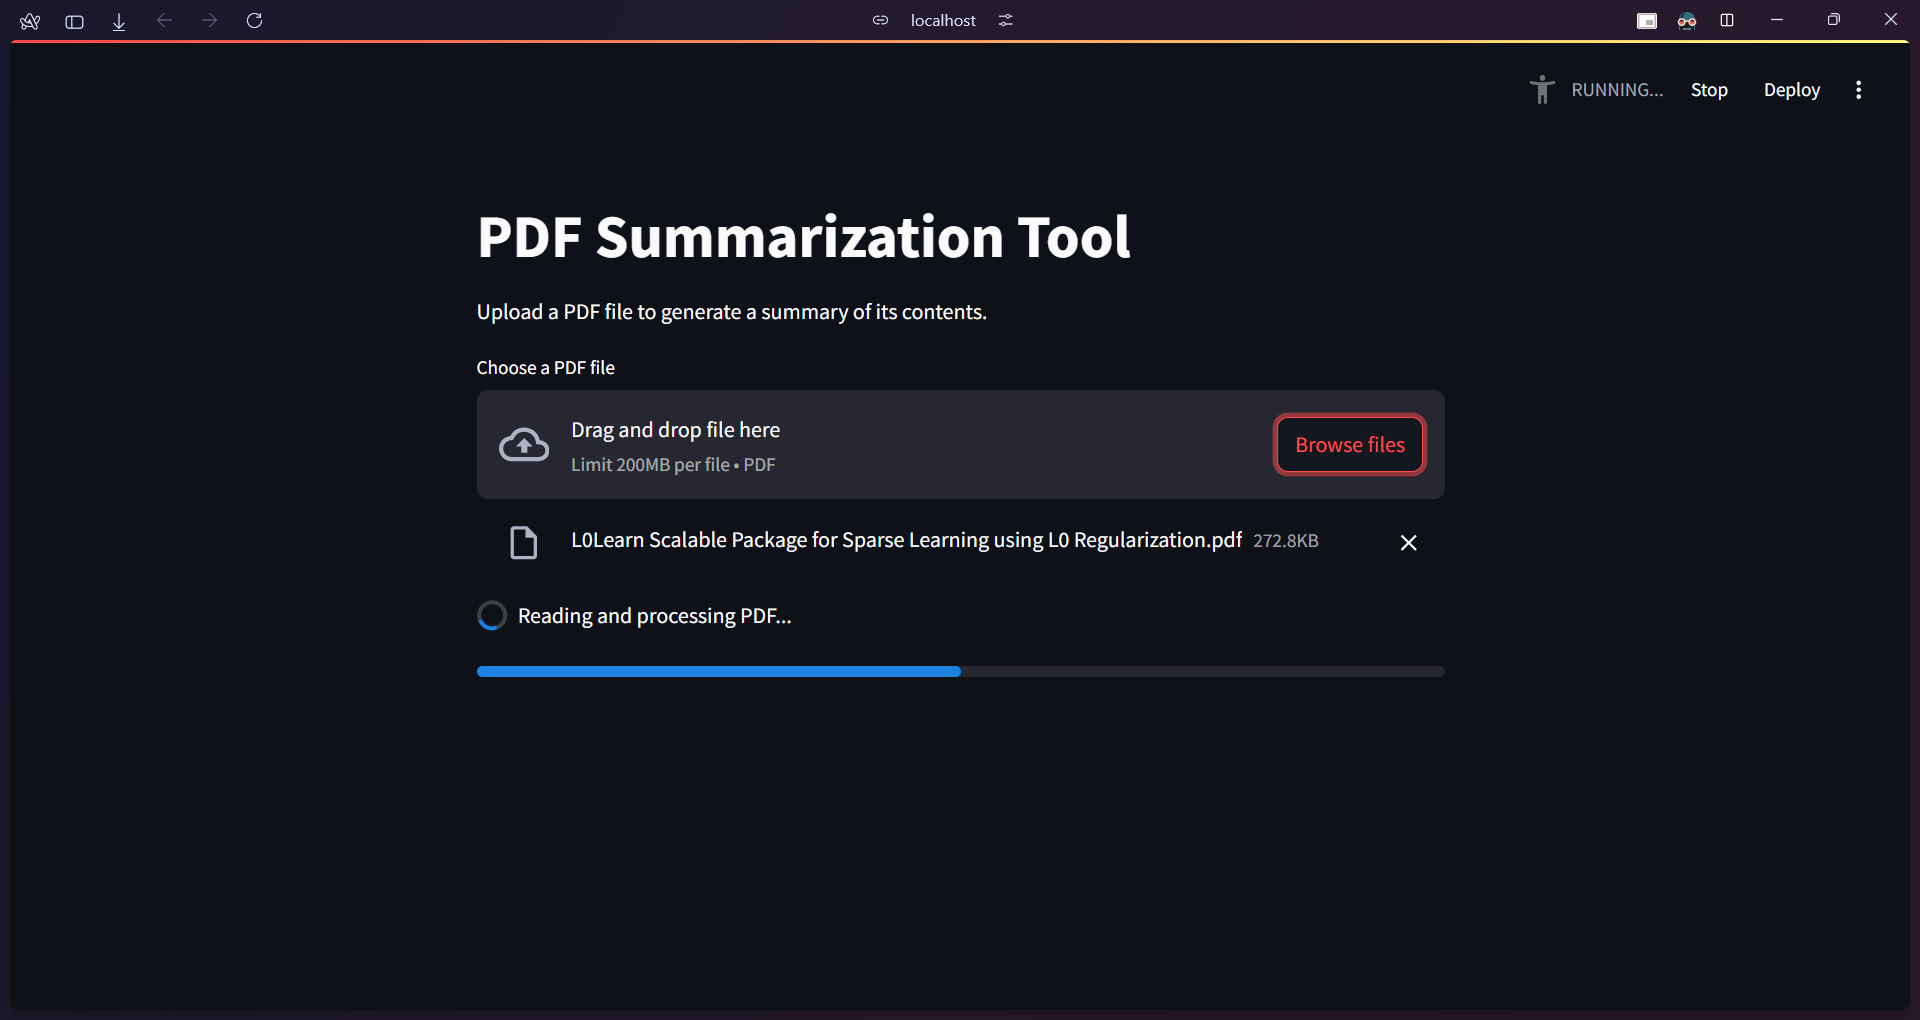

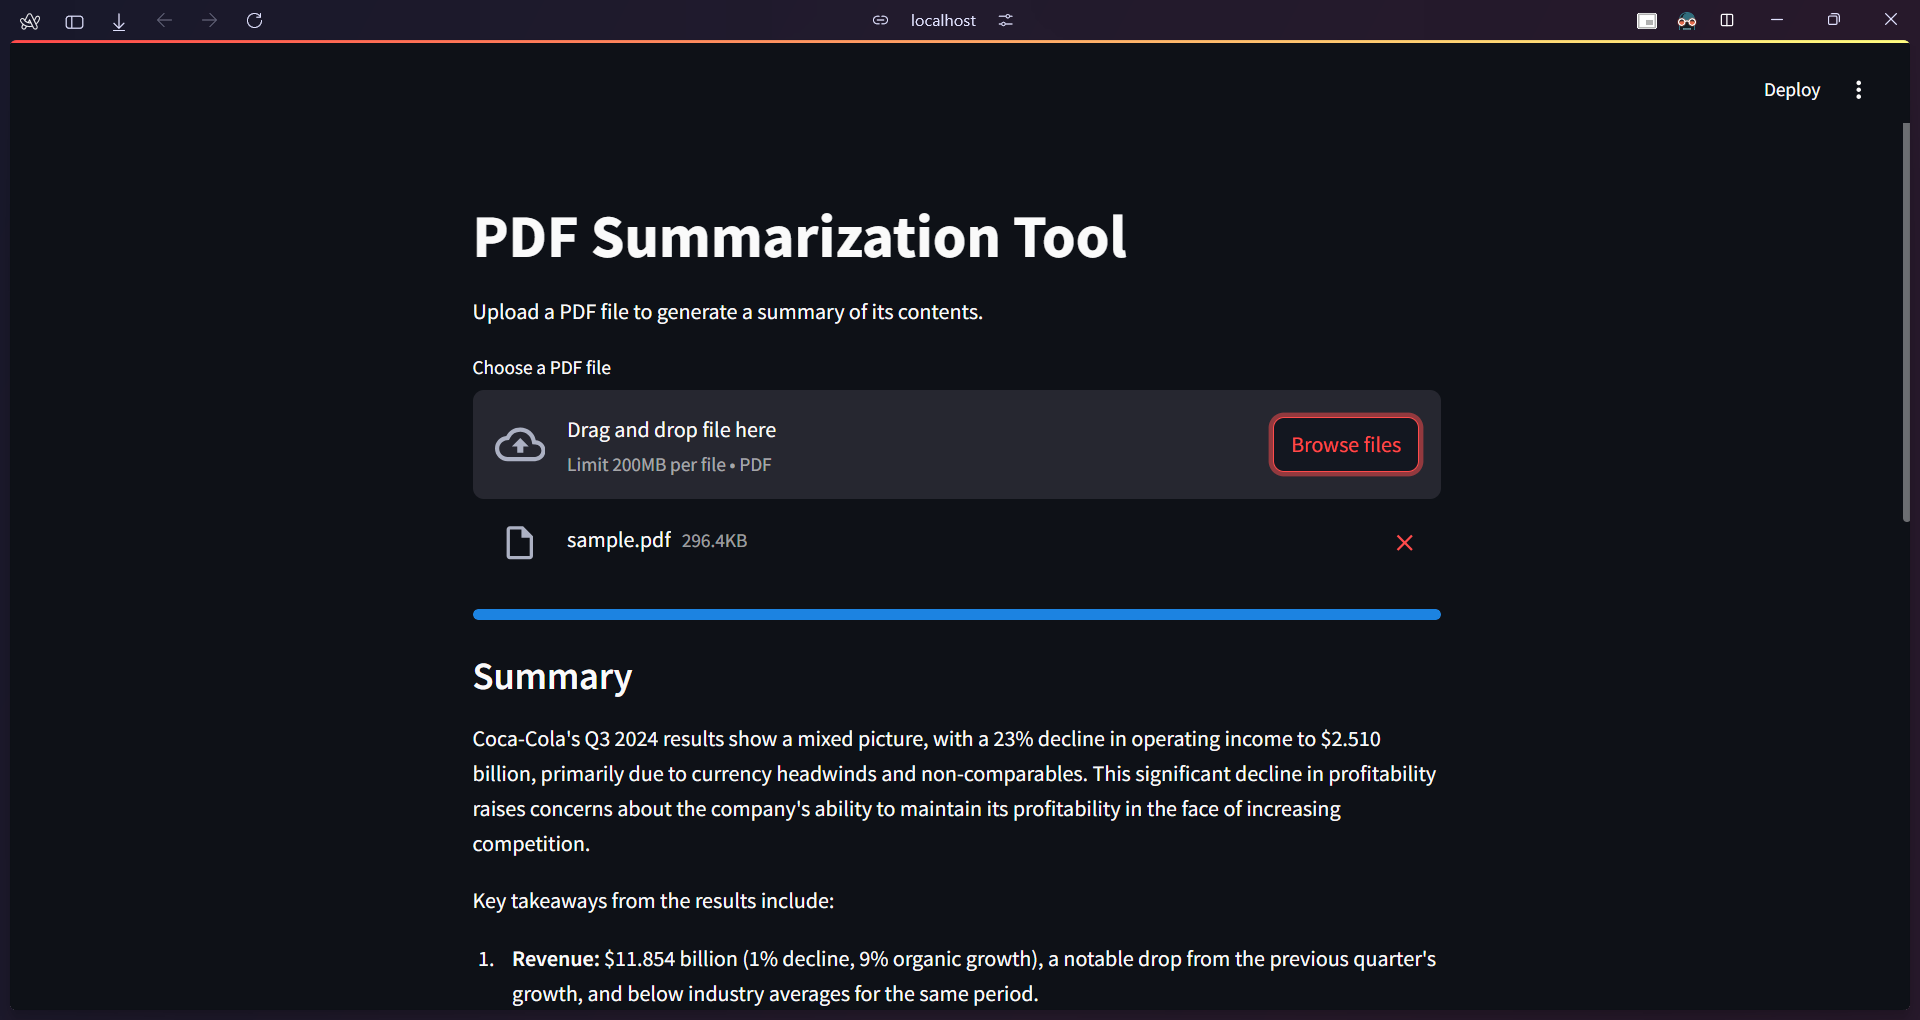
